In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
from imblearn.pipeline import Pipeline
import os
import numpy as np
import matplotlib.pyplot as plt
NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


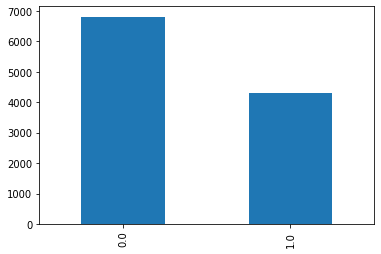

In [2]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [3]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [4]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

In [5]:
X = data.drop('episodeDispositionCode', axis=1)
y = data['episodeDispositionCode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())

In [6]:
# No need: data is fairly balanced
#smt = ADASYN(random_state=0)
#X_train, y_train = smt.fit_resample(X_train, y_train)

# No need: we use tree based method
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)

In [7]:
#clf = lgbm.LGBMClassifier(is_unbalance=True).fit(X_train,y_train) #altalab search used to find best pipline
clf = lgbm.LGBMClassifier().fit(X_train,y_train) 
#altalab search used to find best pipline
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
y_val_pred = clf.predict(X_valid)
y_val_probs = clf.predict_proba(X_valid)[:,1]

In [8]:
print(clf.predict(X_test))

[1. 1. 0. ... 0. 1. 0.]


In [9]:
print(clf.predict_proba(X_test))

[[0.37604993 0.62395007]
 [0.49447817 0.50552183]
 [0.99448513 0.00551487]
 ...
 [0.80940375 0.19059625]
 [0.05434554 0.94565446]
 [0.97565033 0.02434967]]


In [10]:
print(clf.predict_proba(X_test)[:,0]+clf.predict_proba(X_test)[:,1])

[1. 1. 1. ... 1. 1. 1.]


In [11]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

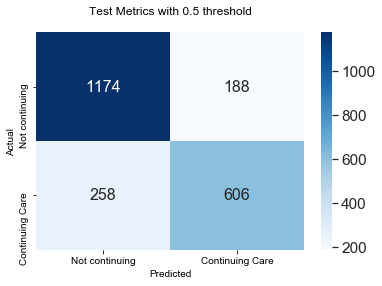

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.819832,0.763224
Recall,0.861968,0.701389
F,0.840372,0.731001
Support,1362.000000,864.000000


In [12]:
plt.title('Test Metrics with 0.5 threshold\n')
get_metrics(y_test, y_pred)

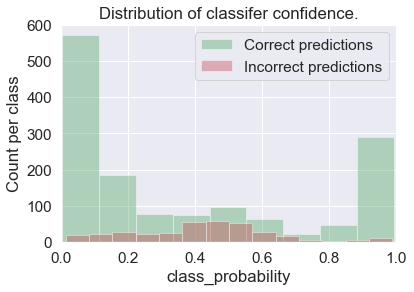

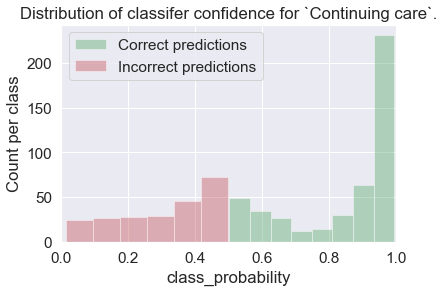

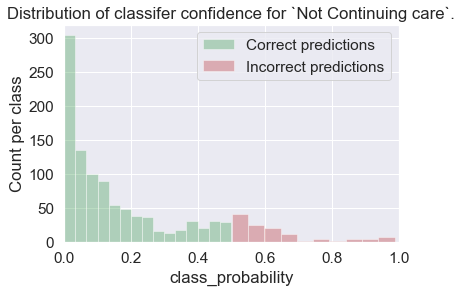

In [13]:
import seaborn as sns

pos_probas = y_val_probs[(y_valid == y_val_pred)]
neg_probas = y_val_probs[(y_valid != y_val_pred)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence.")
plt.legend()
plt.show()


mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 1)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 1)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Continuing care`.")
plt.legend()
plt.show()
mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 0)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 0)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False,  label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Not Continuing care`.")
plt.legend()
plt.show()

We see that for 

## Explaining the decision
We use a method called SHAP (SHapley Additive exPlanations). 
This plot is made of all the points in the validation data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

The explanations of why the model performed the way it did on the test set is as follows.

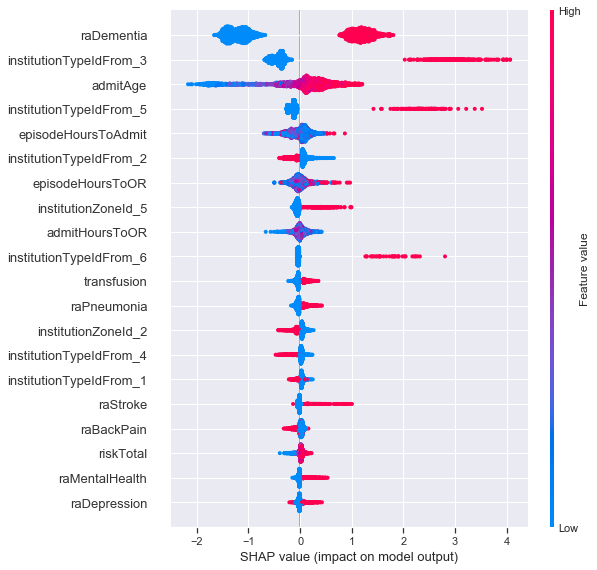

In [14]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns = feat_names ))
shap.summary_plot(shap_values[1], pd.DataFrame(X_test, columns = feat_names ))

- From the SHAP plot above, we can see that the most siginficant effect comes from`raDementia`. Larger values of the feature pushes the model to categorize the patient more to Continuing care. 
- Similarly `admitAge` pushes the model to categorize the patient more to Continuing care. 
- `institutionTypeIdFrom` plays a major role as well. We see that if the patient is coming from `institutionTypeIdFrom` 3 or 5, the patient is likely to be predicted as needing contiuing care. 
- If the patient is coming from `institutionTypeIdFrom` 2,1,4, the patient is likely to be predicted as needing contiuing care. 
- There is a weak effect of `episodeHoursToAdmit`. This is not clear but large values seem to push the model to recommend continuing care. 
- A similar effect is, if `institutionZoneId` is 5 (North), the model is recommending continuing care.  


# Effect of removing uncertain predictions
To test if removing uncertain predictions can help improve the performance of the classifier, we select two thresholds (`th1` and `th2`) that sweep across the range of probability values of the classifer and pick the ones that maximizes the F score. Anything with a probability between the two thresholds will be considered as uncertain. 

In [177]:
# Define costomized cost function

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    #print(residual)
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    
#     loss = np.zeros(residual.shape)
#     loss[residual < 0] = C_p
#     loss[residual > 0] = C_n
    #print(loss)
    cost = np.mean(loss)
    return cost

In [178]:
# Define custom objective function -- Weighted MSE



def custom_asymmetric_objective_lgb(y_true, y_pred,C_p,C_n):
    residual = (y_true - y_pred).astype("float")
    print('\n Residule\t',residual[-10:])
    grad = np.where(residual<=0, -2*C_p*residual, -2*C_n*residual)
    print('\n Gradient\t',grad[-10:])
    hess = np.where(residual<=0, 2*C_p, 2*C_n)
    return grad, hess

def custom_asymmetric_eval_lgb(y_true, y_pred,C_p,C_n):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    #loss = np.zeros(residual.shape)
    #loss[residual < 0] = 1.6
    #loss[residual > 0] = 1
    #print('\n Loss\t',loss)

    return "custom_asymmetric_eval", np.mean(loss), False

In [19]:
# Define custom objective function -- Weighted Logistic Regression


# residual = (y_true - y_pred).astype("float")
#     print('\n Residule\t',residual[:10])
#     grad = np.where(residual<0, .1/(1-y_pred), 1/(-y_pred))
#     print('\n Gradient\t',grad[:10])
#     hess = np.where(residual<0, .1/((1-y_pred)**2), 1/(y_pred**2))
#     return grad, hess

# def custom_asymmetric_eval(y_true, y_pred):     
#     residual = (y_true - y_pred).astype("float")
#     loss = np.where(residual <0, (residual**2)*0.1, residual**2)
#     print('\n Loss\t',loss)

#     return "custom_asymmetric_eval", np.mean(loss), False


In [185]:
# Repredict y_pred_2

# make new model on new value
# Define weights here

c_p=5
c_n=4

custom_asymmetric_objective = lambda x,y: custom_asymmetric_objective_lgb(x, y, c_p, c_n)
custom_asymmetric_eval = lambda x,y: custom_asymmetric_eval_lgb(x, y, c_p, c_n)


# clf2 = lgbm.LGBMClassifier(random_state=33,
#                                early_stopping_rounds = 10,
#                                n_estimators=10000)

clf2 = lgbm.LGBMClassifier()
#clf2.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse",'mae'])
clf2.set_params(**{'objective': custom_asymmetric_objective},metrics= {'binary_logloss', 'auc'})


clf2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

y_pred_2 = clf2.predict(X_test)
y_prob_2 = clf2.predict_proba(X_test)[:,1]
y_val_pred_2 = clf2.predict(X_valid)
y_val_probs_2 = clf2.predict_proba(X_valid)[:,1]





 Residule	 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]

 Gradient	 [-0. -0. -0. -8. -0. -0. -8. -0. -0. -0.]

 Residule	 [-0.0250797  -0.04016795 -0.01666667  0.95983205 -0.00320105 -0.09387145
  0.90960118 -0.00320105 -0.01666667 -0.03589744]

 Gradient	 [ 0.25079702  0.4016795   0.16666667 -7.6786564   0.03201052  0.9387145
 -7.27680945  0.03201052  0.16666667  0.35897436]

 Residule	 [-0.04765143 -0.06304301 -0.03029712  0.92491615 -0.006082   -0.17835575
  0.82824225 -0.006082   -0.03029712 -0.06820513]

 Gradient	 [ 0.47651434  0.63043015  0.30297116 -7.39932919  0.06081999  1.78355753
 -6.62593798  0.06081999  0.30297116  0.68205128]

 Residule	 [-0.06214095 -0.09570341 -0.04036496  0.89225576 -0.00881615 -0.25439163
  0.75501921 -0.00881615 -0.04036496 -0.09934082]

 Gradient	 [ 0.62140949  0.95703405  0.40364959 -7.13804607  0.0881615   2.54391627
 -6.04015364  0.0881615   0.40364959  0.9934082 ]

 Residule	 [-0.07291729 -0.12489339 -0.05385378  0.86306577 -0.01097806 -0.32282392
  0.6891


 Residule	 [-0.12623331 -0.28503285 -0.22083721  0.58476356 -0.06393376 -0.85038722
  0.1479891  -0.02168303 -0.2203944  -0.25103358]

 Gradient	 [ 1.26233306  2.85032851  2.20837207 -4.67810849  0.63933756  8.50387221
 -1.18391277  0.21683029  2.20394398  2.51033584]

 Residule	 [-0.12650563 -0.28530517 -0.22110953  0.58449124 -0.07569867 -0.84461003
  0.14771678 -0.02022507 -0.22066672 -0.2513059 ]

 Gradient	 [ 1.26505625  2.85305171  2.21109526 -4.67592993  0.75698671  8.4461003
 -1.18173421  0.20225071  2.20666718  2.51305904]

 Residule	 [-0.15048142 -0.28528339 -0.22108775  0.58451302 -0.07567689 -0.84458825
  0.14300899 -0.02020329 -0.22064494 -0.25418118]

 Gradient	 [ 1.50481423  2.85283394  2.21087749 -4.67610415  0.75676895  8.44588253
 -1.14407189  0.20203294  2.20644941  2.54181177]

 Residule	 [-0.15298678 -0.28675673 -0.22218505  0.58341572 -0.09395713 -0.82334411
  0.14153565 -0.02062574 -0.22174224 -0.25384092]

 Gradient	 [ 1.52986776  2.86756726  2.22185051 -4.6673

In [186]:
Cost(y_val_pred_2, y_valid, c_p, c_n)

0.8376404494382023

In [112]:
print("Validation set size",len(y_valid),'\n')
print("test set size",len(y_test),'\n')

Validation set size 1780 

test set size 2226 



                <----------Classifer output (probability)--------->
                 
|-------------------------------------*---------------------------------------------|
0   'Not continuing care'           theta        'Continuing care'                  1

In [187]:
# mimic what's been done but only use one decision thredhold
y_pred_3 = np.ones(y_valid.shape)
cmin = 999999
pmax = 0

for theta in np.linspace(0,1,10):

    y_pred_3 = np.ones(y_valid.shape)
    y_pred_3[y_val_probs <= theta] = 0
    y_pred_3[y_val_probs > theta] = 1
   
    # Confusion metrix for each thredhold
    cm = confusion_matrix(y_valid, y_pred_3)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
 

    class_names =  [ 'Continuing Care'] 
    metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_3, average='binary') )
        
    #print(metrics,'\n')        
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    cost_to_be_mimimized = Cost(y_pred_3, y_valid, c_p, c_n)
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: F score = {np.around(var_to_be_maximized,2)}")
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: cost = {np.around(Cost(y_pred_3, y_valid, c_p, c_n),2)}")
    
    
    # Track the best decision thredhold
    if cmin > (cost_to_be_mimimized):
        cmin = (cost_to_be_mimimized)
        pmax = theta
print(f'\n Best cutoffs cost = {np.around(cmin,3)} for Not continuing care <{np.around(pmax,2)},  and continuing care >{np.around(pmax,2)}')





 Best cutoffs cost = 0.83 for Not continuing care <0.67,  and continuing care >0.67


In [188]:
print(y_pred_2)

[1. 0. 0. ... 0. 1. 0.]


In [189]:
print(y_pred_test)

[1. 1. 0. ... 1. 1. 0.]


In [190]:
# Compare costs on test set

print('\nCost for flse positive is\t',c_p,"\tCost for false negative is\t",c_n)
print('Cost for default model is\t',np.round(Cost(y_pred, y_test, c_p, c_n),3))
print('Cost for direct optimized model is\t',np.round(Cost(y_pred_2, y_test, c_p, c_n),4))

y_pred_test = np.ones(y_test.shape)
y_pred_test[y_prob <= pmax] = 0
print('Cost for changing thredhold is\t',np.round(Cost(y_pred_test, y_test, c_p, c_n),4))


Cost for flse positive is	 5 	Cost for false negative is	 4
Cost for default model is	 0.886
Cost for direct optimized model is	 0.8603
Cost for changing thredhold is	 0.9043


In [135]:
metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
#df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
# df_cm.index.name = 'Class'
# df_cm.columns.name = 'Metrics'
# display(df_cm)
print(metrics)

[[8.19832402e-01 7.63224181e-01]
 [8.61967695e-01 7.01388889e-01]
 [8.40372226e-01 7.31001206e-01]
 [1.36200000e+03 8.64000000e+02]]


We see that including any prediction in undertain class reduces the performance of the algorithm.

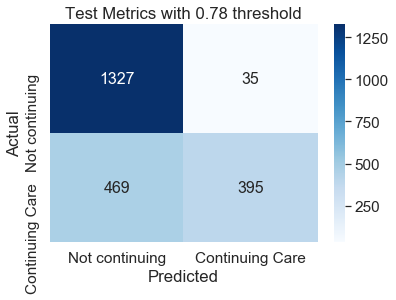

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.738864,0.918605
Recall,0.974302,0.457176
F,0.840405,0.610510
Support,1362.000000,864.000000


In [107]:
plt.title(f'Test Metrics with {np.around(pmax,2)} threshold')
get_metrics(y_test, y_prob>pmax)

We see that with further tuning performance of the classifier can be improved. 

## Test of reliability
To test if the classifer can maintain performance we create 10 random splits of the data in the training-test set and then repeat the process of evaluating the algorithm.

In [19]:
clf_not_tuned =  lgbm.LGBMClassifier() 
pipeline = Pipeline([('oversample', smt), ('scale', scaler), ('classifer', clf_not_tuned)])
metrics = []
means = []
standard_devs = []
for metric in [ 'recall','precision','f1']:
    kfold = ShuffleSplit(n_splits=10, test_size=0.20, random_state=NPSEED)
    all_fold_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=f'{metric}_macro')
    m = all_fold_results.mean()*100.0
    s = all_fold_results.std()*100.0
    print(f"{metric}: %.2f%% (%.2f%%)" % ( m, s))
    metrics.append(metric)
    means.append(m)
    standard_devs.append(s)
plt.errorbar(metrics, means, standard_devs, linestyle='None', marker='X')
plt.show()

NameError: name 'smt' is not defined